In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, utils
from PIL import Image
import os
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips

In [ ]:
# --- 1. Core Components (Encoder and AdaIN) ---
# pre-trained VGG-19 for the encoder.

class VGGEncoder(nn.Module):
    """
    VGG-19 Encoder Network.
    This class loads a pre-trained VGG-19 model and extracts features from
    intermediate layers (relu1_1, relu2_1, relu3_1, relu4_1) which are
    used to calculate style and content losses.
    """
    def __init__(self):
        super(VGGEncoder, self).__init__()
        # Load pre-trained VGG19 model features
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        
        # Define the layers to be used for feature extraction
        self.slice1 = vgg[:2]    # relu1_1
        self.slice2 = vgg[2:7]   # relu2_1
        self.slice3 = vgg[7:12]  # relu3_1
        self.slice4 = vgg[12:21] # relu4_1

        # Freeze the weights as we are only using it for feature extraction
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h1 = self.slice1(x)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        h4 = self.slice4(h3)
        return h1, h2, h3, h4

def adaptive_instance_normalization(content_feat, style_feat):
    """
    Adaptive Instance Normalization (AdaIN) layer.
    This function takes content features and style features and aligns the
    mean and standard deviation of the content features to match those of the
    style features.
    """
    assert content_feat.size()[:2] == style_feat.size()[:2]
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

def calc_mean_std(feat, eps=1e-5):
    """Calculate mean and standard deviation along spatial dimensions."""
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

# --- 2. Decoder Architectures ---
# Here we define the four different decoder architectures

class ConvReLUUpsample(nn.Module):
    """A standard block for the baseline decoder."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, upsample=True):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv(x)
        x = self.relu(x)
        return x

class BaselineDecoder(nn.Module):
    """
    The baseline decoder, a mirrored version of the VGG encoder.
    FIXED: This version is corrected to have the right number of upsampling layers
    (3) to match the output size to the input size (e.g., 32x32 -> 256x256).
    """
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            ConvReLUUpsample(512, 256, upsample=False), # -> 32x32
            ConvReLUUpsample(256, 256),                # Upsamples to 64x64
            ConvReLUUpsample(256, 128),                # Upsamples to 128x128
            ConvReLUUpsample(128, 64),                 # Upsamples to 256x256
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.decoder(x)

class ResNetBlock(nn.Module):
    """A Residual Block, the core component of a ResNet-style architecture."""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += residual
        return out

class ResNetDecoder(nn.Module):
    """A ResNet-style decoder that uses ResNetBlocks."""
    def __init__(self, num_blocks=2):
        super().__init__()
        self.decoder = nn.Sequential(
            ConvReLUUpsample(512, 256, upsample=False),
            *[ResNetBlock(256) for _ in range(num_blocks)],
            ConvReLUUpsample(256, 256),
            *[ResNetBlock(256) for _ in range(num_blocks)],
            ConvReLUUpsample(256, 128),
            *[ResNetBlock(128) for _ in range(num_blocks)],
            ConvReLUUpsample(128, 64),
            *[ResNetBlock(64) for _ in range(num_blocks)],
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.decoder(x)

class SelfAttention(nn.Module):
    """A simple self-attention module."""
    def __init__(self, in_channels):
        super().__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class AttentionDecoder(nn.Module):
    """
    A decoder that incorporates self-attention modules.
    """
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            ConvReLUUpsample(512, 256, upsample=False), # -> 32x32
            SelfAttention(256),
            ConvReLUUpsample(256, 256),                # Upsamples to 64x64
            ConvReLUUpsample(256, 128),                # Upsamples to 128x128
            SelfAttention(128),
            ConvReLUUpsample(128, 64),                 # Upsamples to 256x256
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
    def forward(self, x):
        return self.decoder(x)

class UNetDecoder(nn.Module):
    """A U-Net style decoder that uses skip connections from the encoder."""
    def __init__(self):
        super(UNetDecoder, self).__init__()
        # Decoder blocks. Upsampling is handled explicitly in the forward pass.
        self.up_conv1 = ConvReLUUpsample(512, 256, upsample=False)
        self.up_conv2 = ConvReLUUpsample(256 + 256, 128, upsample=False)
        self.up_conv3 = ConvReLUUpsample(128 + 128, 64, upsample=False)
        self.up_conv4 = ConvReLUUpsample(64 + 64, 64, upsample=False)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, stylized_content_feat, encoder_feats):
        e1, e2, e3, _ = encoder_feats

        # Path: AdaIN -> relu3_1
        d1 = self.up_conv1(stylized_content_feat)                             # [B, 256, 32x32]
        d1_upsampled = F.interpolate(d1, scale_factor=2, mode='nearest')      # [B, 256, 64x64]
        d1_cat = torch.cat([d1_upsampled, e3], dim=1)                         # Concat with e3 -> [B, 512, 64x64]

        # Path: -> relu2_1
        d2 = self.up_conv2(d1_cat)                                            # [B, 128, 64x64]
        d2_upsampled = F.interpolate(d2, scale_factor=2, mode='nearest')      # [B, 128, 128x128]
        d2_cat = torch.cat([d2_upsampled, e2], dim=1)                         # Concat with e2 -> [B, 256, 128x128]
        
        # Path: -> relu1_1
        d3 = self.up_conv3(d2_cat)                                            # [B, 64, 128x128]
        d3_upsampled = F.interpolate(d3, scale_factor=2, mode='nearest')      # [B, 64, 256x256]
        d3_cat = torch.cat([d3_upsampled, e1], dim=1)                         # Concat with e1 -> [B, 128, 256x256]

        # Final layers
        d4 = self.up_conv4(d3_cat)                                            # [B, 64, 256x256]
        output = self.final_conv(d4)                                          # [B, 3, 256x256]
        
        return output


In [3]:
# --- Testing Models ---

def load_and_transform_image(path, size=512):
    """Loads and transforms a single image from a file path."""
    try:
        image = Image.open(path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image file not found at {path}")
        return None
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0) # Add batch dimension

def test_models(content_path, style_path, output_dir="inference_results", image_size=256):
    """
    Loads trained decoder models and generates stylized images for comparison.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load Content and Style Images ---
    content_image = load_and_transform_image(content_path, image_size).to(device)
    style_image = load_and_transform_image(style_path, image_size).to(device)

    if content_image is None or style_image is None:
        return

    # --- Define Models to Test ---
    decoder_info = {
        "Baseline": (lambda: BaselineDecoder(), "output/hyperparams2/BaselineDecoder/weights/decoder_final.pth"),
        "ResNet": (lambda: ResNetDecoder(num_blocks=3), "output/hyperparams2/ResNetDecoder/weights/decoder_final.pth"),
        "Attention": (lambda: AttentionDecoder(), "output/hyperparams2/AttentionDecoder/weights/decoder_final.pth"),
        "U-Net": (lambda: UNetDecoder(), "output/hyperparams2/UNetDecoder/weights/decoder_final.pth"),
    }
    
    # --- Shared Encoder ---
    encoder = VGGEncoder().to(device)
    encoder.eval()

    # --- Generate Stylized Images ---
    output_images = []
    output_labels = []

    # Use no_grad for inference as we don't need to compute gradients
    with torch.no_grad():
        # Get content and style features once
        content_feats = encoder(content_image)
        style_feats = encoder(style_image)
        
        for name, (decoder_class, model_path) in decoder_info.items():
            print(f"Testing model: {name}...")
            
            if not os.path.exists(model_path):
                print(f"  - Warning: Model weights not found at {model_path}. Skipping.")
                continue

            # Instantiate and load the trained decoder
            decoder = decoder_class().to(device)
            decoder.load_state_dict(torch.load(model_path, map_location=device))
            decoder.eval() # Set model to evaluation mode

            # Perform style transfer
            stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])

            if isinstance(decoder, UNetDecoder):
                output = decoder(stylized_feat, content_feats)
            else:
                output = decoder(stylized_feat)
            
            output_images.append(output.cpu())
            output_labels.append(name)
            
    # --- Save Results ---
    if not output_images:
        print("No models were tested. Exiting.")
        return

    os.makedirs(output_dir, exist_ok=True)
    
    # Create a grid for comparison
    # We add the original content and style images at the beginning
    grid_images = [content_image.cpu(), style_image.cpu()] + output_images
    
    # Save the comparison grid
    grid = utils.make_grid(torch.cat(grid_images, 0), nrow=2) # 2 images per row
    output_path = os.path.join(output_dir, "comparison_grid.png")
    utils.save_image(grid, output_path)
    
    print(f"\nInference complete. Comparison grid saved to: {output_path}")

In [4]:
images = ["0845", "0846", "0847", "0848", "0849", "0850"]
for img in images:
    content_image_path = f"data/DIV2K/DIV2K_valid_HR/{img}.png"
    style_image_path = f"data/selected_styles/Vincent_van_Gogh/Vincent_van_Gogh_10.jpg"

    test_models(content_image_path, style_image_path, output_dir=f"inference_results/{img}", image_size=256)

Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/xdg-cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:01<00:00, 327MB/s] 


Testing model: Baseline...
Testing model: ResNet...
Testing model: Attention...
Testing model: U-Net...

Inference complete. Comparison grid saved to: inference_results/0845/comparison_grid.png
Using device: cuda
Testing model: Baseline...
Testing model: ResNet...
Testing model: Attention...
Testing model: U-Net...

Inference complete. Comparison grid saved to: inference_results/0846/comparison_grid.png
Using device: cuda
Testing model: Baseline...
Testing model: ResNet...
Testing model: Attention...
Testing model: U-Net...

Inference complete. Comparison grid saved to: inference_results/0847/comparison_grid.png
Using device: cuda
Testing model: Baseline...
Testing model: ResNet...
Testing model: Attention...
Testing model: U-Net...

Inference complete. Comparison grid saved to: inference_results/0848/comparison_grid.png
Using device: cuda
Testing model: Baseline...
Testing model: ResNet...
Testing model: Attention...
Testing model: U-Net...

Inference complete. Comparison grid saved t

In [5]:
# --- 2. Evaluation Logic ---
def load_image(path, size=512):
    try:
        img = Image.open(path).convert('RGB')
    except FileNotFoundError: return None
    return transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])(img).unsqueeze(0)

def tensor_to_numpy(tensor):
    return tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().numpy()

def main(content_img='0820'):
    # --- Configuration ---
    # Define the experiments (style weights) and the corresponding folder names.
    EXPERIMENTS = {
        3: 'hyperparams4', 7: 'hyperparams3', 10: 'hyperparams2',
        20: 'hyperparams1', 30: 'hyperparams5'
    }
    # Define the decoder classes and their trained folder names.
    DECODERS = {
        'BaselineDecoder': lambda: BaselineDecoder(),
        'ResNetDecoder': lambda: ResNetDecoder(num_blocks=3), 
        'AttentionDecoder': lambda: AttentionDecoder(),
        'UNetDecoder': lambda: UNetDecoder()
    }
    # Define the content/style pairs you want to test for visual comparison.
    TEST_PAIRS = [
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/Vincent_van_Gogh/Vincent_van_Gogh_368.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/images/Rembrandt/Rembrandt_38.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/Claude_Monet/Claude_Monet_10.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/William_Turner/William_Turner_2.jpg'),
    ]
    IMAGE_SIZE = 256
    RESULTS_DIR = f"paper_results/{content_img}"
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    encoder = VGGEncoder().to(device).eval()
    lpips_fn = lpips.LPIPS(net='vgg').to(device)
    all_results = []
    
    # --- 1. Quantitative Evaluation: Calculate and Store Metrics ---
    print("\n--- Starting Quantitative Evaluation ---")
    for sw, exp_folder in EXPERIMENTS.items():
        for dec_name, dec_constructor in DECODERS.items():
            model_path = f"output/{exp_folder}/{dec_name}/weights/decoder_final.pth"
            if not os.path.exists(model_path):
                print(f"SKIPPING: {model_path} not found.")
                continue

            decoder = dec_constructor().to(device)
            decoder.load_state_dict(torch.load(model_path, map_location=device))
            decoder.eval()
            
            # Use the first content image for metric calculations
            content_path, _ = TEST_PAIRS[0]
            content_tensor = load_image(content_path, IMAGE_SIZE).to(device)

            for style_path in glob.glob(f"output/{exp_folder}/{dec_name}/images/sample_*.png"):
                style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
                if style_tensor is None: continue

                with torch.no_grad():
                    start_time = time.time()
                    content_feats = encoder(content_tensor)
                    style_feats = encoder(style_tensor)
                    stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                    if isinstance(decoder, UNetDecoder):
                        output_tensor = decoder(stylized_feat, content_feats)
                    else:
                        output_tensor = decoder(stylized_feat)
                    inference_time = (time.time() - start_time) * 1000 # in ms

                # Calculate metrics
                c_np, o_np = tensor_to_numpy(content_tensor), tensor_to_numpy(output_tensor)
                current_psnr = psnr(c_np, o_np, data_range=1)
                current_ssim = ssim(c_np, o_np, data_range=1, multichannel=True, channel_axis=2)
                current_lpips = lpips_fn(content_tensor, output_tensor).item()

                all_results.append({
                    'style_weight': sw, 'decoder': dec_name, 'psnr': current_psnr,
                    'ssim': current_ssim, 'lpips': current_lpips,
                    'inference_time_ms': inference_time
                })

    # Save aggregated results to CSV
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(f"{RESULTS_DIR}/quantitative_metrics.csv", index=False)
    print(f"\nQuantitative metrics saved to {RESULTS_DIR}/quantitative_metrics.csv")

    # --- 2. Qualitative Evaluation: Generate Visual Grids ---
    print("\n--- Starting Qualitative Evaluation ---")
    for i, (content_path, style_path) in enumerate(TEST_PAIRS):
        content_tensor = load_image(content_path, IMAGE_SIZE).to(device)
        style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
        if content_tensor is None or style_tensor is None: continue

        # Grid 1: Compare decoders for a fixed style weight (e.g., 10)
        sw_for_grid = 10
        exp_folder = EXPERIMENTS[sw_for_grid]
        grid_imgs = [content_tensor, style_tensor]
        for dec_name, dec_constructor in DECODERS.items():
            model_path = f"output/{exp_folder}/{dec_name}/weights/decoder_final.pth"
            if not os.path.exists(model_path): continue
            decoder = dec_constructor().to(device); decoder.load_state_dict(torch.load(model_path, map_location=device)); decoder.eval()
            with torch.no_grad():
                content_feats, style_feats = encoder(content_tensor), encoder(style_tensor)
                stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                output = decoder(stylized_feat, content_feats) if isinstance(decoder, UNetDecoder) else decoder(stylized_feat)
                grid_imgs.append(output)
        utils.save_image(torch.cat(grid_imgs, 0), f"{RESULTS_DIR}/comparison_decoders_pair{i+1}_sw{sw_for_grid}.png", nrow=len(DECODERS)+2)
        print(f"Generated decoder comparison grid for test pair {i+1}")

        # Grid 2: Compare style weights for a fixed decoder (e.g., U-Net)
        dec_for_grid = 'UNetDecoder'
        dec_constructor = DECODERS[dec_for_grid]
        grid_imgs = [content_tensor, style_tensor]
        for sw, exp_folder in EXPERIMENTS.items():
            model_path = f"output/{exp_folder}/{dec_for_grid}/weights/decoder_final.pth"
            if not os.path.exists(model_path): continue
            decoder = dec_constructor().to(device); decoder.load_state_dict(torch.load(model_path, map_location=device)); decoder.eval()
            with torch.no_grad():
                content_feats, style_feats = encoder(content_tensor), encoder(style_tensor)
                stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                output = decoder(stylized_feat, content_feats) if isinstance(decoder, UNetDecoder) else decoder(stylized_feat)
                grid_imgs.append(output)
        utils.save_image(torch.cat(grid_imgs, 0), f"{RESULTS_DIR}/comparison_style_weights_pair{i+1}_{dec_for_grid}.png", nrow=len(EXPERIMENTS)+2)
        print(f"Generated style weight comparison grid for {dec_for_grid} and test pair {i+1}")

        # Grid 3 : Compare styles for UNet with SW=10
        print("\n--- Generating Final U-Net Comparison Grid (SW=10) ---")
        sw_unet, dec_unet = 10, 'UNetDecoder'
        exp_folder_unet = EXPERIMENTS[sw_unet]
        model_path_unet = f"output/{exp_folder_unet}/{dec_unet}/weights/decoder_final.pth"

        if os.path.exists(model_path_unet):
            unet_model = DECODERS[dec_unet]().to(device)
            unet_model.load_state_dict(torch.load(model_path_unet, map_location=device))
            unet_model.eval()

            content_path, _ = TEST_PAIRS[0]
            content_tensor = load_image(content_path, IMAGE_SIZE).to(device)
            
            top_row, bottom_row = [torch.ones_like(content_tensor)], [content_tensor]

            with torch.no_grad():
                for _, style_path in TEST_PAIRS:
                    style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
                    if style_tensor is None: 
                        top_row.append(torch.zeros_like(content_tensor))
                        bottom_row.append(torch.zeros_like(content_tensor))
                        continue

                    top_row.append(style_tensor)
                    
                    content_feats, style_feats = encoder(content_tensor), encoder(style_tensor)
                    stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                    output = unet_model(stylized_feat, content_feats)
                    bottom_row.append(output)

            final_grid = torch.cat(top_row + bottom_row, 0)
            utils.save_image(final_grid, f"{RESULTS_DIR}/final_unet_comparison_grid.png", nrow=5)
            print(f"Generated final U-Net comparison grid at {RESULTS_DIR}/final_unet_comparison_grid.png")
        else:
            print(f"SKIPPING: U-Net model for SW=7 not found at {model_path_unet}")

    # --- 3. Plotting ---
    print("\n--- Generating Plots ---")
    sns.set_theme(style="whitegrid")

    # Plot Loss Curves
    fig, axes = plt.subplots(len(DECODERS), 1, figsize=(10, 5 * len(DECODERS)), sharex=True)
    for ax, dec_name in zip(axes, DECODERS.keys()):
        for sw, exp_folder in EXPERIMENTS.items():
            log_path = f"output/{exp_folder}/{dec_name}/loss_log.csv"
            if not os.path.exists(log_path): continue
            loss_df = pd.read_csv(log_path)
            ax.plot(loss_df['step'], loss_df['total_loss'].rolling(window=10).mean(), label=f'SW={sw}')
        ax.set_title(f'Total Loss ({dec_name})'); ax.set_ylabel('Loss (10-step rolling avg)'); ax.legend()
    plt.xlabel('Training Step'); plt.tight_layout(); plt.savefig(f"{RESULTS_DIR}/plot_loss_curves.png")
    print("Generated loss curve plot.")

    # Plot Metrics vs. Style Weight
    metric_cols = ['psnr', 'ssim', 'lpips']
    fig, axes = plt.subplots(len(metric_cols), 1, figsize=(10, 5 * len(metric_cols)), sharex=True)
    for ax, metric in zip(axes, metric_cols):
        sns.lineplot(data=results_df, x='style_weight', y=metric, hue='decoder', marker='o', ax=ax)
        ax.set_title(f'{metric.upper()} vs. Style Weight'); ax.set_ylabel(metric.upper())
    plt.xlabel('Style Weight'); plt.tight_layout(); plt.savefig(f"{RESULTS_DIR}/plot_metrics_vs_style_weight.png")
    print("Generated metrics vs. style weight plot.")
    
    # Plot Inference Time
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='decoder', y='inference_time_ms', errorbar=None)
    plt.title('Average Inference Time per Decoder'); plt.ylabel('Time (ms)'); plt.xlabel('Decoder')
    plt.xticks(rotation=15); plt.tight_layout(); plt.savefig(f"{RESULTS_DIR}/plot_inference_time.png")
    print("Generated inference time plot.")

    print("\nEvaluation complete. All artifacts saved in 'paper_results/' directory.")

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:01<00:00, 426MB/s] 


Loading model from: /home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth

--- Starting Quantitative Evaluation ---

Quantitative metrics saved to paper_results/0820/quantitative_metrics.csv

--- Starting Qualitative Evaluation ---
Generated decoder comparison grid for test pair 1
Generated style weight comparison grid for UNetDecoder and test pair 1

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/0820/final_unet_comparison_grid.png
Generated decoder comparison grid for test pair 2
Generated style weight comparison grid for UNetDecoder and test pair 2

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/0820/final_unet_comparison_grid.png
Generated decoder comparison grid for test pair 3
Generated style weight comparison grid for UNetDecoder and test pair 3

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated fin

/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth

--- Starting Quantitative Evaluation ---

Quantitative metrics saved to paper_results/0834/quantitative_metrics.csv

--- Starting Qualitative Evaluation ---
Generated decoder comparison grid for test pair 1
Generated style weight comparison grid for UNetDecoder and test pair 1

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/0834/final_unet_comparison_grid.png
Generated decoder comparison grid for test pair 2
Generated style weight comparison grid for UNetDecoder and test pair 2

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/0834/final_unet_comparison_grid.png
Generated decoder comparison grid for test pair 3
Generated style weight comparison grid for UNetDecoder and test pair 3

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated fin

/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth

--- Starting Quantitative Evaluation ---

Quantitative metrics saved to paper_results/0841/quantitative_metrics.csv

--- Starting Qualitative Evaluation ---
Generated decoder comparison grid for test pair 1
Generated style weight comparison grid for UNetDecoder and test pair 1

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/0841/final_unet_comparison_grid.png
Generated decoder comparison grid for test pair 2
Generated style weight comparison grid for UNetDecoder and test pair 2

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/0841/final_unet_comparison_grid.png
Generated decoder comparison grid for test pair 3
Generated style weight comparison grid for UNetDecoder and test pair 3

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated fin

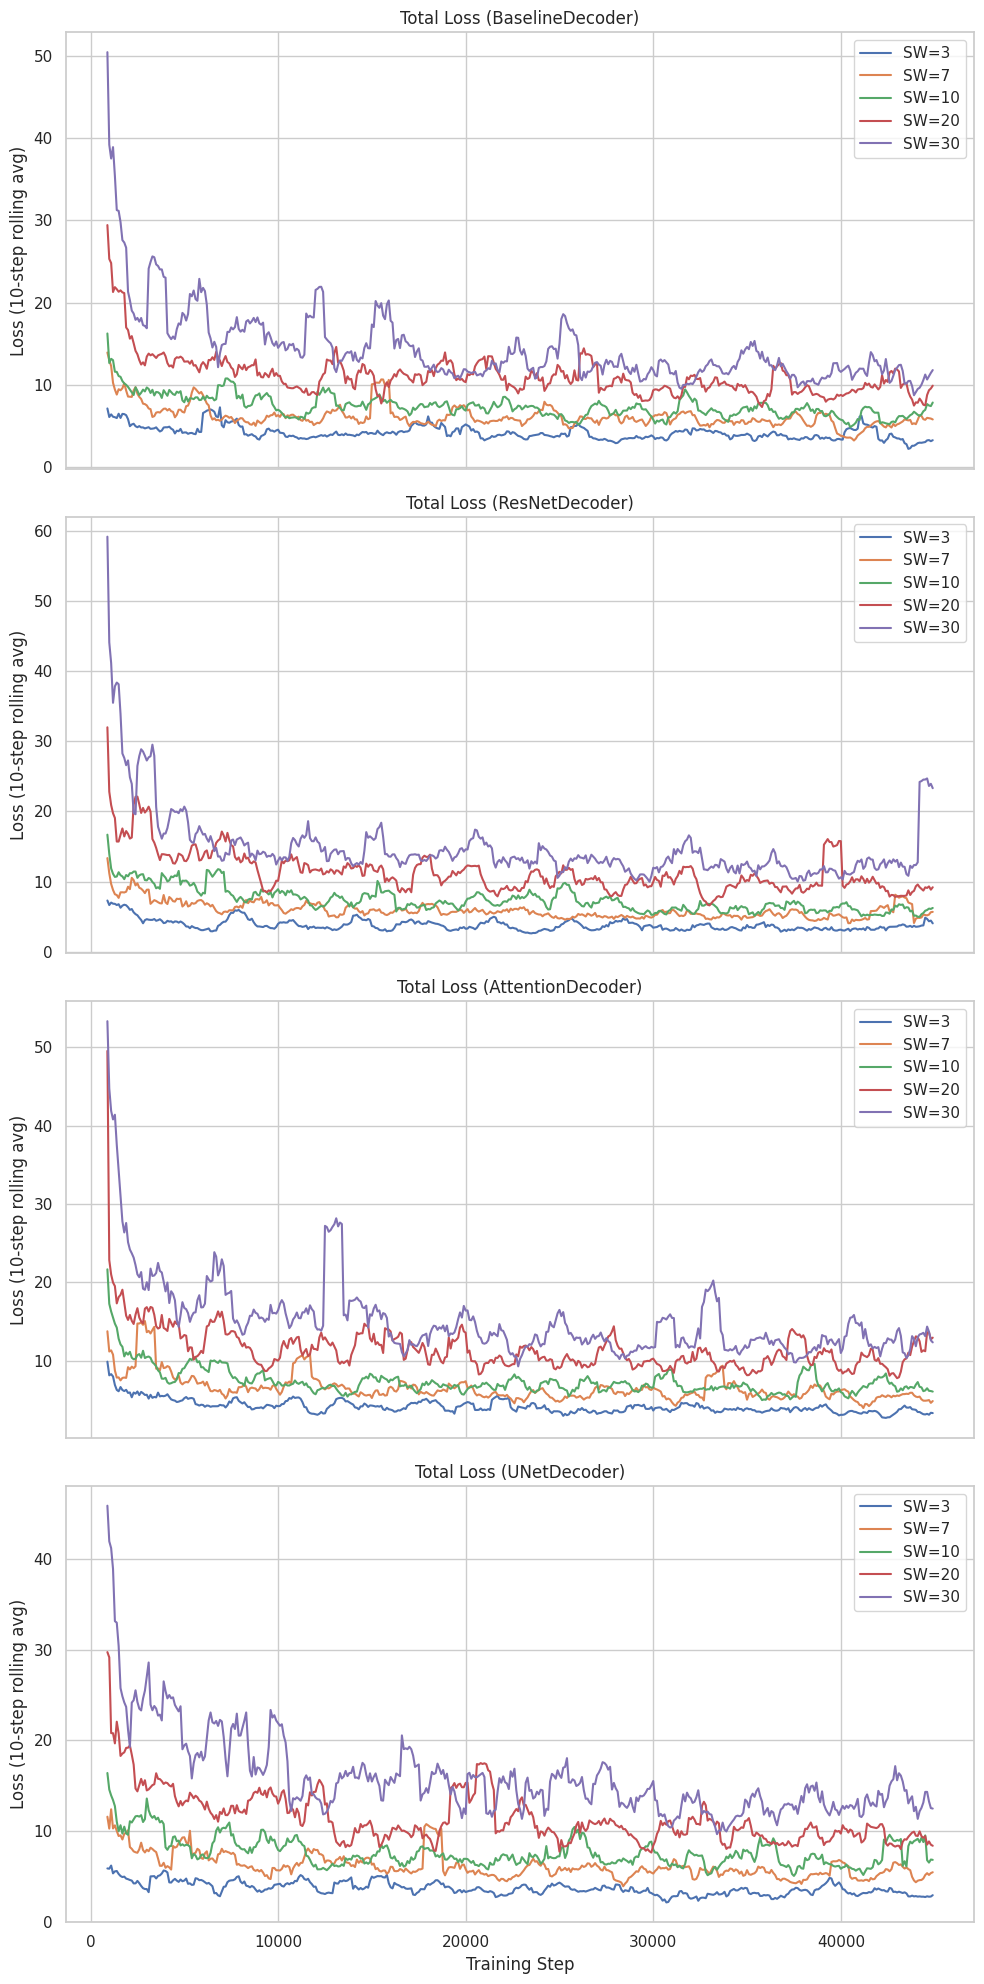

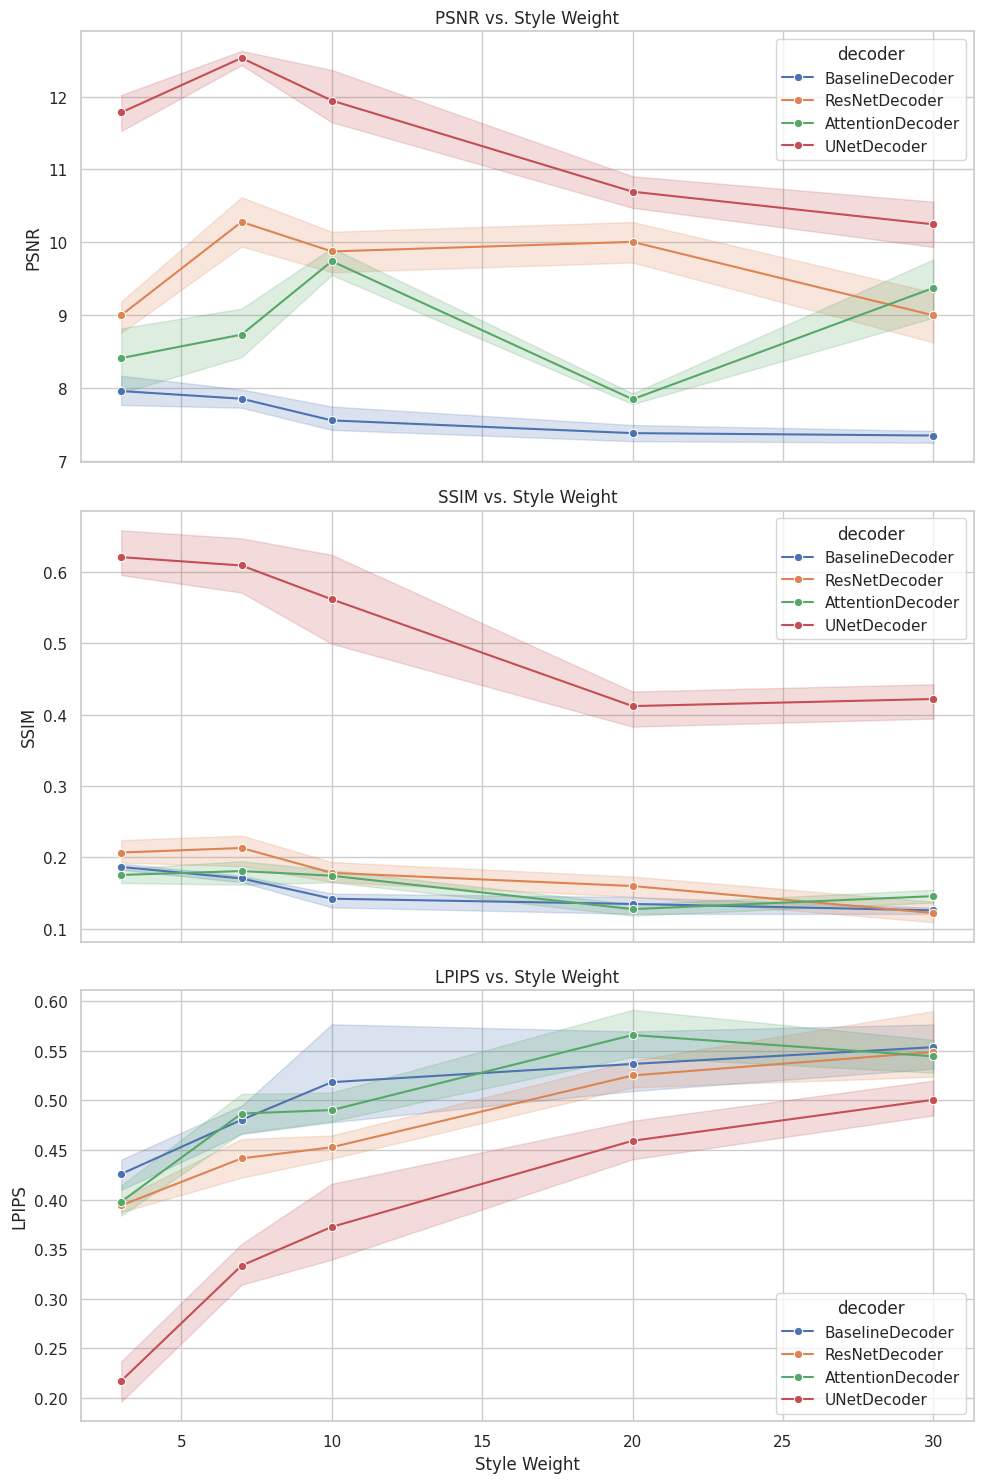

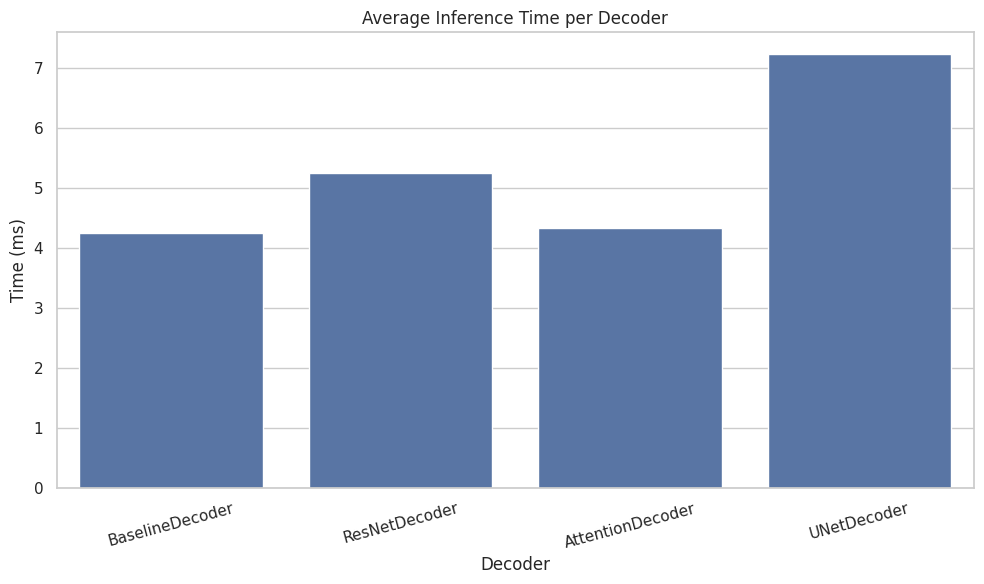

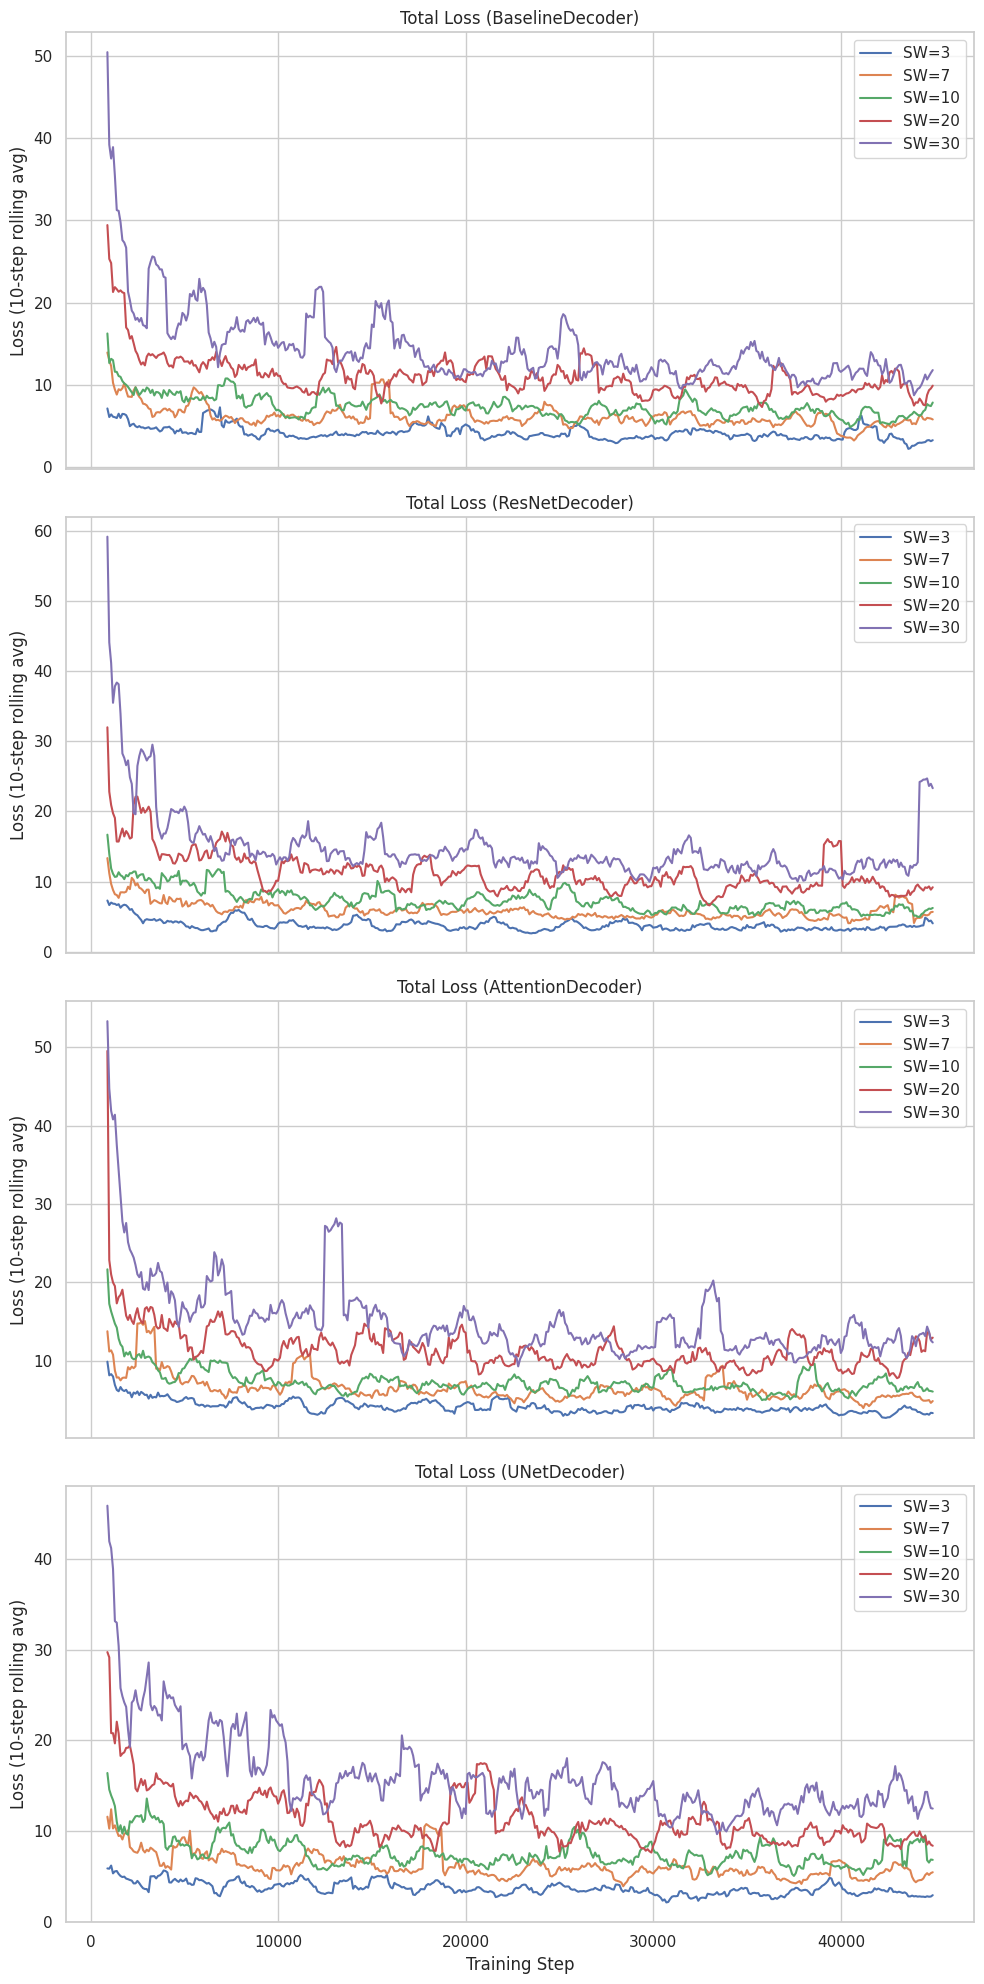

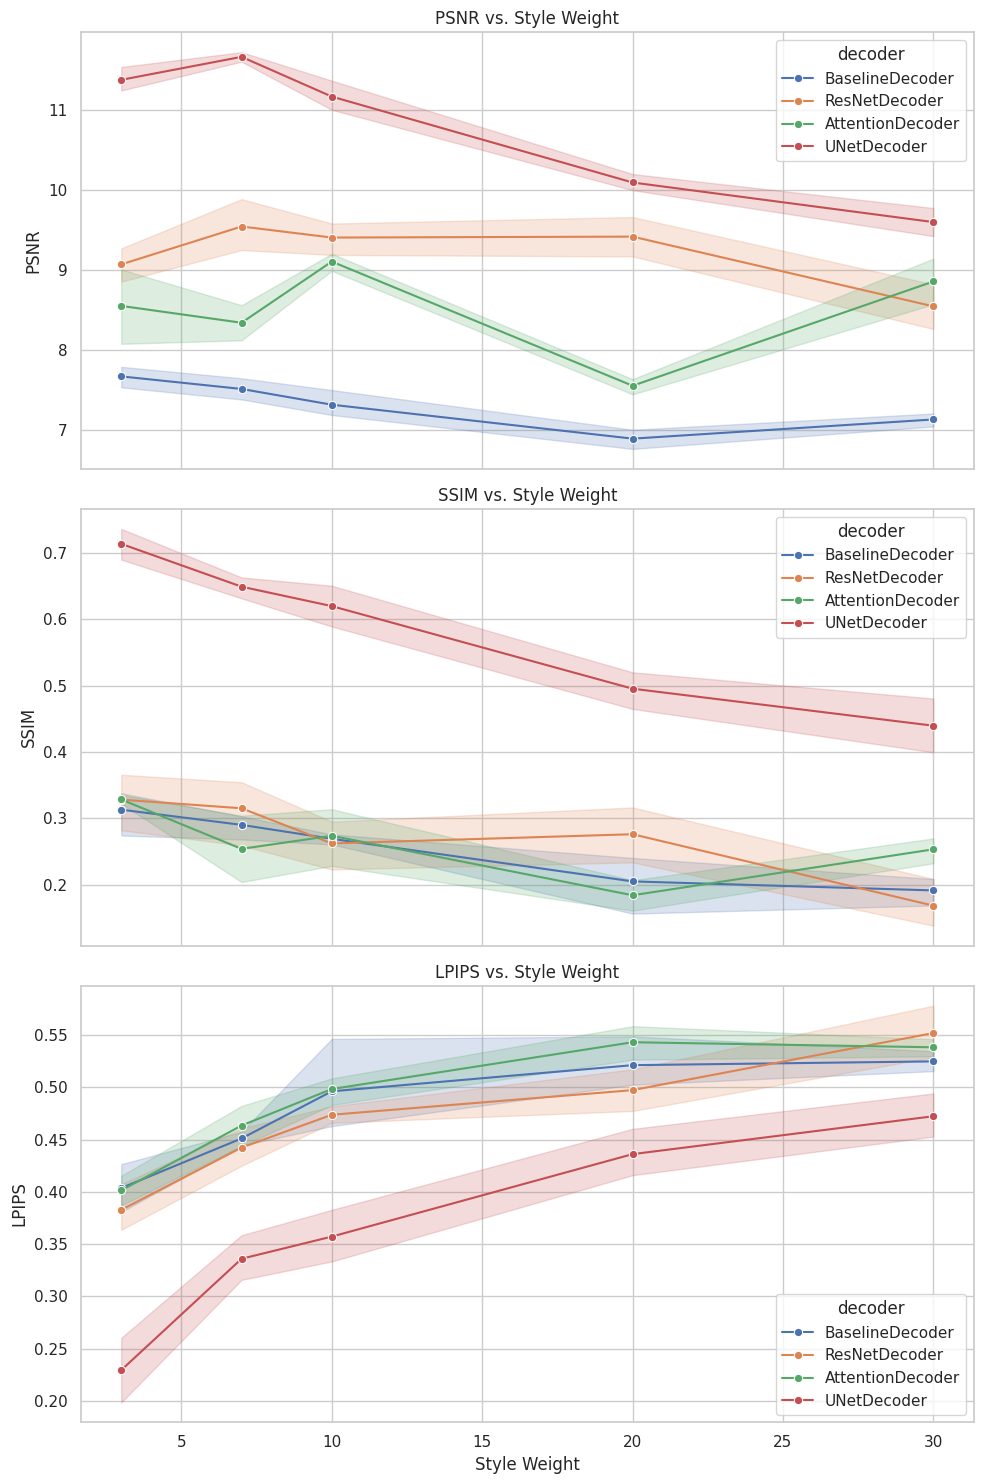

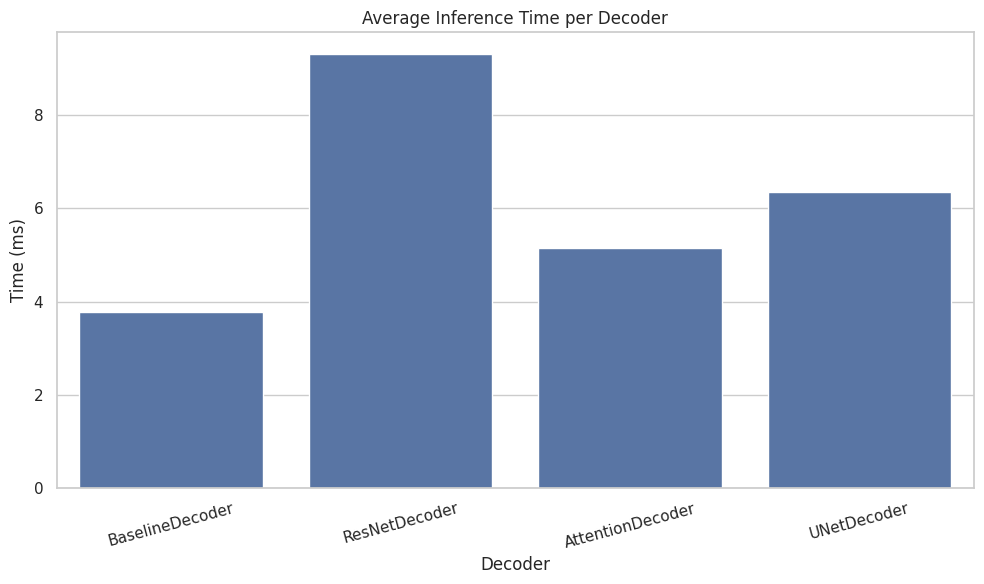

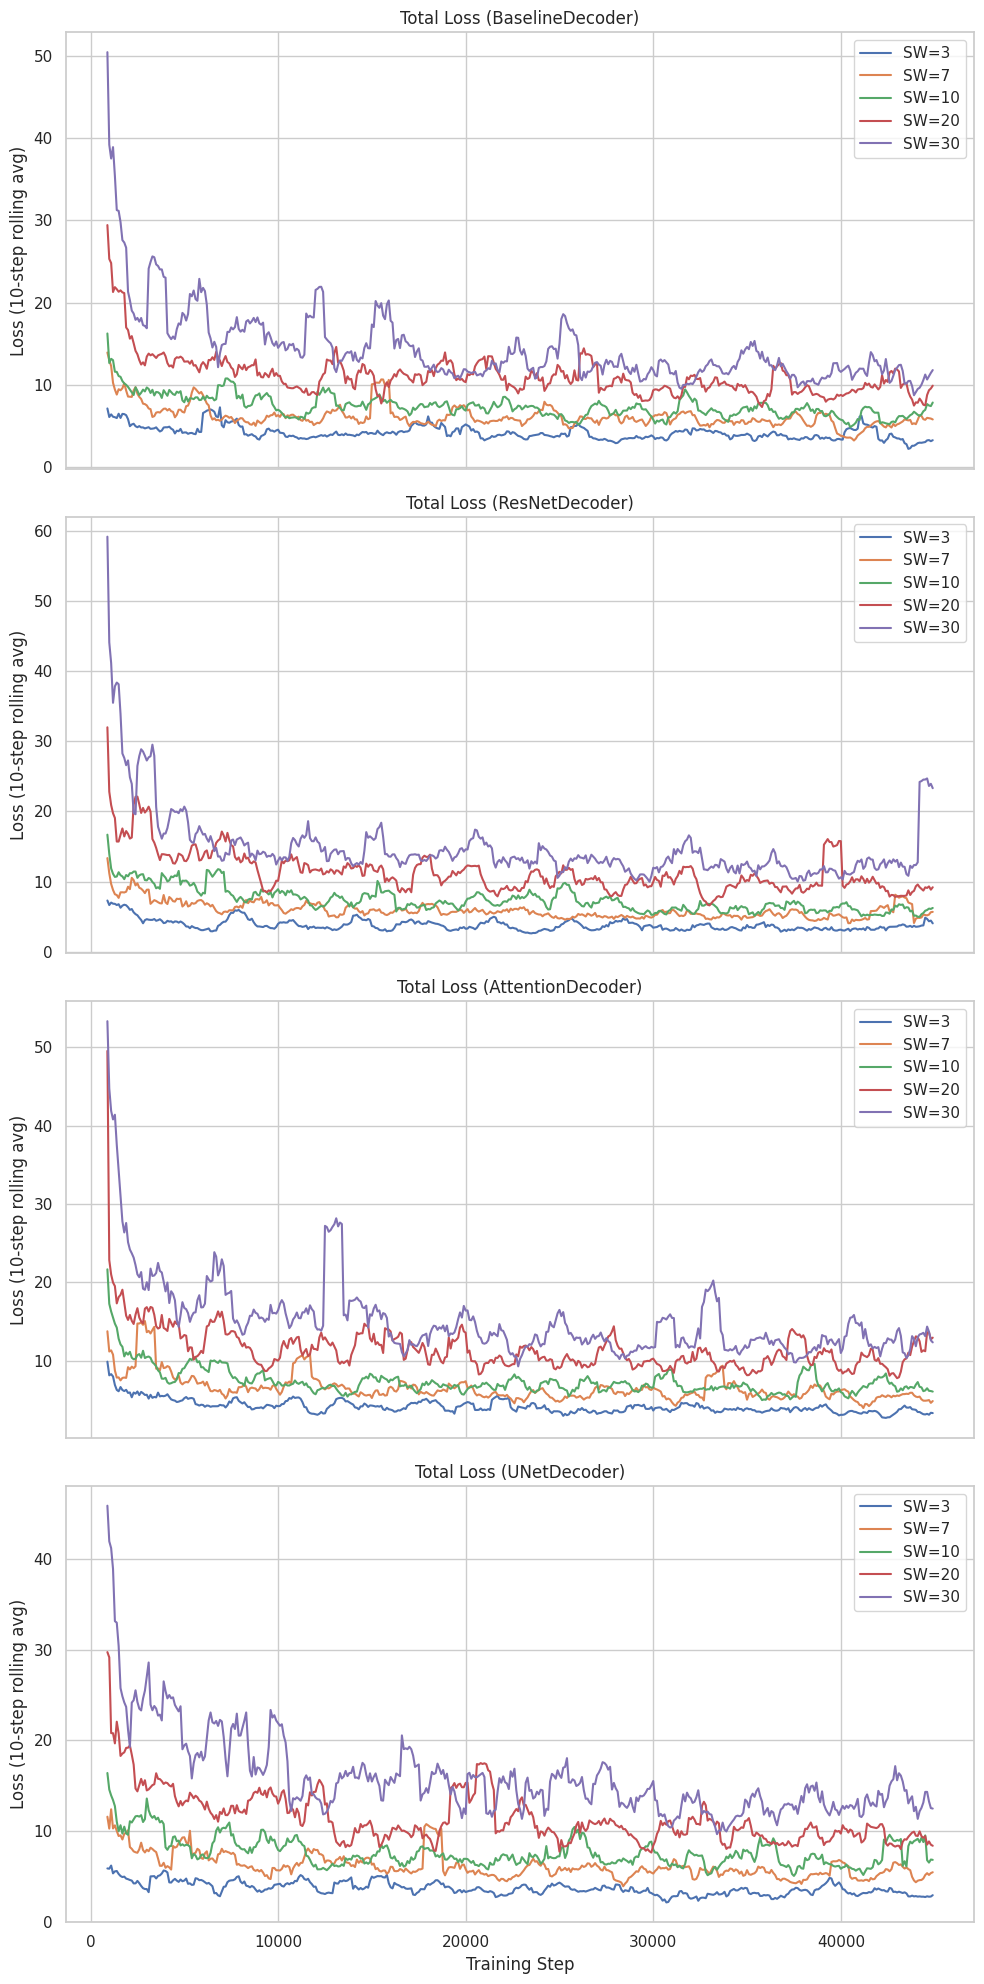

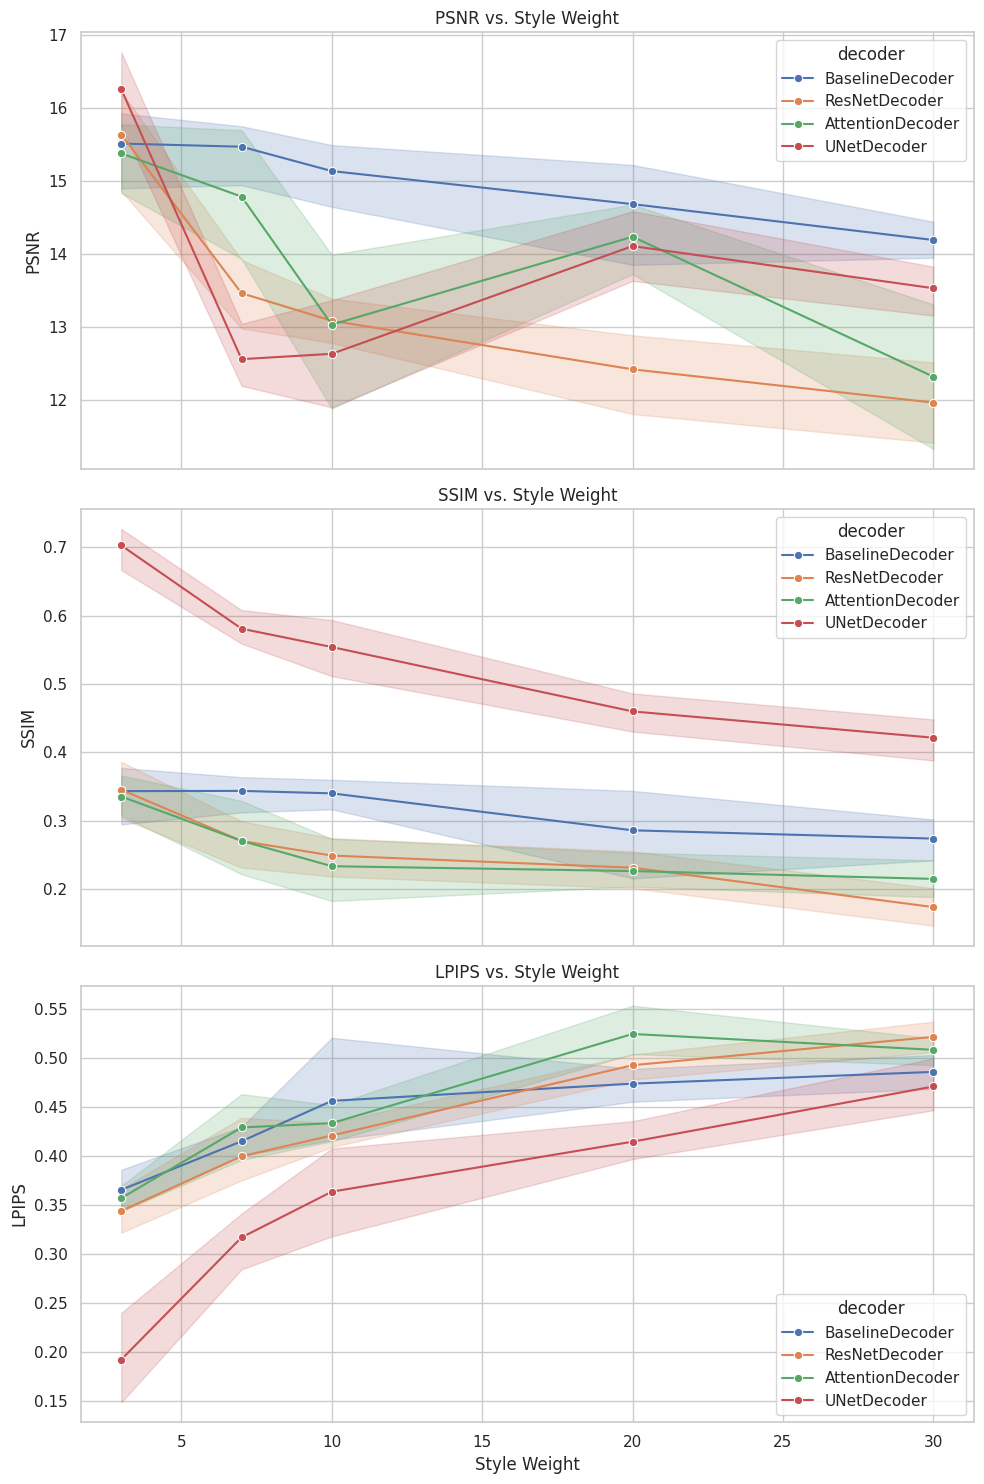

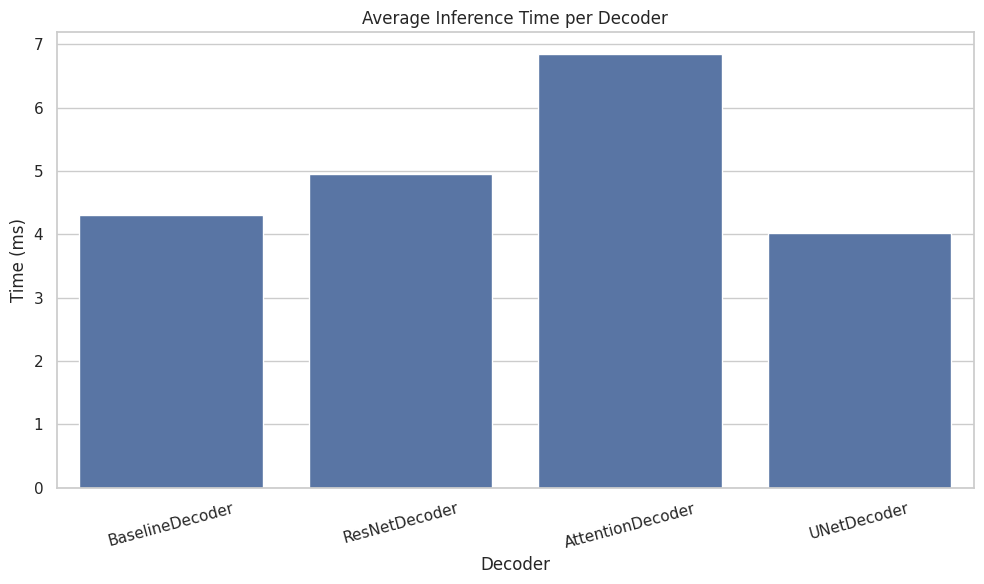

In [ ]:
main(content_img='0820')
main(content_img='0834')
main(content_img='0841')

In [7]:
def test_unet(content_img='0820'):
    # --- Configuration ---
    DECODERS = {
        'UNetDecoder': lambda: UNetDecoder()
    }
    # Define the content/style pairs you want to test for visual comparison.
    TEST_PAIRS = [
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/Vincent_van_Gogh/Vincent_van_Gogh_368.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/images/Michelangelo/Michelangelo_4.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/Claude_Monet/Claude_Monet_10.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/William_Turner/William_Turner_2.jpg'),
        (f'data/DIV2K/DIV2K_valid_HR/{content_img}.png', 'data/selected_styles/Georges_Seurat/Georges_Seurat_1.jpg'),
    ]
    IMAGE_SIZE = 256
    RESULTS_DIR = f"paper_results/Unet/{content_img}"
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    encoder = VGGEncoder().to(device).eval()
    lpips_fn = lpips.LPIPS(net='vgg').to(device)
    all_results = []
    
    # --- 1. Quantitative Evaluation: Calculate and Store Metrics ---
    print("\n--- Starting Quantitative Evaluation ---")
    # for sw, exp_folder in EXPERIMENTS.items():
    for dec_name, dec_constructor in DECODERS.items():
        model_path = f"output/{dec_name}/weights/decoder_final.pth"
        if not os.path.exists(model_path):
            print(f"SKIPPING: {model_path} not found.")
            continue

        decoder = dec_constructor().to(device)
        decoder.load_state_dict(torch.load(model_path, map_location=device))
        decoder.eval()
        
        # Use the first content image for metric calculations
        content_path, _ = TEST_PAIRS[0]
        content_tensor = load_image(content_path, IMAGE_SIZE).to(device)

        for style_path in glob.glob(f"output/{dec_name}/images/sample_*.png"):
            style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
            if style_tensor is None: continue

            with torch.no_grad():
                start_time = time.time()
                content_feats = encoder(content_tensor)
                style_feats = encoder(style_tensor)
                stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                if isinstance(decoder, UNetDecoder):
                    output_tensor = decoder(stylized_feat, content_feats)
                else:
                    output_tensor = decoder(stylized_feat)
                inference_time = (time.time() - start_time) * 1000 # in ms

            # Calculate metrics
            c_np, o_np = tensor_to_numpy(content_tensor), tensor_to_numpy(output_tensor)
            current_psnr = psnr(c_np, o_np, data_range=1)
            current_ssim = ssim(c_np, o_np, data_range=1, multichannel=True, channel_axis=2)
            current_lpips = lpips_fn(content_tensor, output_tensor).item()

            all_results.append({
                'style_weight': 10, 'decoder': dec_name, 'psnr': current_psnr,
                'ssim': current_ssim, 'lpips': current_lpips,
                'inference_time_ms': inference_time
            })

    # Save aggregated results to CSV
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(f"{RESULTS_DIR}/quantitative_metrics.csv", index=False)
    print(f"\nQuantitative metrics saved to {RESULTS_DIR}/quantitative_metrics.csv")

    # --- 2. Qualitative Evaluation: Generate Visual Grids ---
    print("\n--- Starting Qualitative Evaluation ---")
    for i, (content_path, style_path) in enumerate(TEST_PAIRS):
        content_tensor = load_image(content_path, IMAGE_SIZE).to(device)
        style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
        if content_tensor is None or style_tensor is None: continue

        # Grid 2: Compare style weights for a fixed decoder (e.g., U-Net)
        dec_for_grid = 'UNetDecoder'
        dec_constructor = DECODERS[dec_for_grid]
        model_path = f"output/{dec_for_grid}/weights/decoder_final.pth"

        if os.path.exists(model_path):
            decoder = dec_constructor().to(device)
            decoder.load_state_dict(torch.load(model_path, map_location=device))
            decoder.eval()

            grid_imgs = [content_tensor, style_tensor]
            
            # Define the different style levels you want to test
            style_levels = [0.2, 0.4, 0.6, 0.8, 1.0] 

            with torch.no_grad():
                content_feats = encoder(content_tensor)
                style_feats = encoder(style_tensor)
                
                # This is the fully stylized feature map
                fully_stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])

                for alpha in style_levels:
                    # Interpolate between content features and stylized features
                    interpolated_feat = alpha * fully_stylized_feat + (1 - alpha) * content_feats[-1]

                    # Decode the interpolated features
                    if isinstance(decoder, UNetDecoder):
                        output = decoder(interpolated_feat, content_feats)
                    else:
                        output = decoder(interpolated_feat)
                    grid_imgs.append(output)

            # Save the grid of images showing different style strengths
            utils.save_image(
                torch.cat(grid_imgs, 0), 
                f"{RESULTS_DIR}/comparison_style_levels_pair{i+1}_{dec_for_grid}.png", 
                nrow=len(style_levels) + 2 # +2 for original content and style images
            )
            print(f"Generated style level comparison grid for {dec_for_grid} and test pair {i+1}")

        # Grid 3 : Compare styles for UNet with SW=10
        print("\n--- Generating Final U-Net Comparison Grid (SW=10) ---")
        sw_unet, dec_unet = 10, 'UNetDecoder'
        model_path_unet = f"output/{dec_unet}/weights/decoder_final.pth"

        if os.path.exists(model_path_unet):
            unet_model = DECODERS[dec_unet]().to(device)
            unet_model.load_state_dict(torch.load(model_path_unet, map_location=device))
            unet_model.eval()

            content_path, _ = TEST_PAIRS[0]
            content_tensor = load_image(content_path, IMAGE_SIZE).to(device)
            
            top_row, bottom_row = [torch.ones_like(content_tensor)], [content_tensor]

            with torch.no_grad():
                for _, style_path in TEST_PAIRS:
                    style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
                    if style_tensor is None: 
                        top_row.append(torch.zeros_like(content_tensor))
                        bottom_row.append(torch.zeros_like(content_tensor))
                        continue

                    top_row.append(style_tensor)
                    
                    content_feats, style_feats = encoder(content_tensor), encoder(style_tensor)
                    stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                    output = unet_model(stylized_feat, content_feats)
                    bottom_row.append(output)

            final_grid = torch.cat(top_row + bottom_row, 0)
            utils.save_image(final_grid, f"{RESULTS_DIR}/final_unet_comparison_grid.png", nrow=5)
            print(f"Generated final U-Net comparison grid at {RESULTS_DIR}/final_unet_comparison_grid.png")
        else:
            print(f"SKIPPING: U-Net model for SW=10 not found at {model_path_unet}")

    print("\nEvaluation complete. All artifacts saved in 'paper_results/' directory.")
test_unet(content_img='0814')  # Change '0845' to any other image ID as needed
test_unet(content_img='0820')  # Change '0845' to any other image ID as needed
test_unet(content_img='0823')  # Change '0845' to any other image ID as needed
test_unet(content_img='0830')  # Change '0845' to any other image ID as needed
test_unet(content_img='0831')  # Change '0845' to any other image ID as needed
test_unet(content_img='0834')  # Change '0845' to any other image ID as needed
test_unet(content_img='0836')  # Change '0845' to any other image ID as needed

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth

--- Starting Quantitative Evaluation ---

Quantitative metrics saved to paper_results/Unet/0814/quantitative_metrics.csv

--- Starting Qualitative Evaluation ---
Generated style level comparison grid for UNetDecoder and test pair 1

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/Unet/0814/final_unet_comparison_grid.png
Generated style level comparison grid for UNetDecoder and test pair 2

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/Unet/0814/final_unet_comparison_grid.png
Generated style level comparison grid for UNetDecoder and test pair 3

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/Unet/0814/final_unet_comparison_grid.png
Generated style level comparison grid for UNetDecoder a

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth

--- Starting Quantitative Evaluation ---

Quantitative metrics saved to paper_results/Unet/0820/quantitative_metrics.csv

--- Starting Qualitative Evaluation ---
Generated style level comparison grid for UNetDecoder and test pair 1

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/Unet/0820/final_unet_comparison_grid.png
Generated style level comparison grid for UNetDecoder and test pair 2

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/Unet/0820/final_unet_comparison_grid.png
Generated style level comparison grid for UNetDecoder and test pair 3

--- Generating Final U-Net Comparison Grid (SW=10) ---
Generated final U-Net comparison grid at paper_results/Unet/0820/final_unet_comp

In [8]:
def generate_final_grid(content_imgs):
    """
    Generates a single, large comparison grid showing multiple content images,
    stylized by multiple style images at various intensity levels.
    """
    # --- Configuration ---
    DECODERS = {
        'UNetDecoder': lambda: UNetDecoder()
    }
    
    # Define multiple content images to include in the grid
    CONTENT_IDS = content_imgs
    CONTENT_PATHS = [f'data/DIV2K/DIV2K_valid_HR/{img_id}.png' for img_id in CONTENT_IDS]

    # Define the style images
    STYLE_PATHS = [
        'data/selected_styles/Vincent_van_Gogh/Vincent_van_Gogh_368.jpg',
        'data/selected_styles/Georges_Seurat/Georges_Seurat_7.jpg',
        'data/selected_styles/Claude_Monet/Claude_Monet_10.jpg',
        'data/images/Michelangelo/Michelangelo_4.jpg',
        'data/images/Diego_Velazquez/Diego_Velazquez_8.jpg',
        'data/images/Leonardo_da_Vinci/Leonardo_da_Vinci_121.jpg',
        'data/selected_styles/William_Turner/William_Turner_2.jpg',
    ]
    
    IMAGE_SIZE = 256
    RESULTS_DIR = "paper_results/Unet_Grid"
    DEC_NAME = 'UNetDecoder'
    MODEL_PATH = f"output/{DEC_NAME}/weights/decoder_final.pth"
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    if not os.path.exists(MODEL_PATH):
        print(f"FATAL: Decoder model not found at {MODEL_PATH}. Exiting.")
        return

    encoder = VGGEncoder().to(device).eval()
    decoder = UNetDecoder().to(device)
    decoder.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    decoder.eval()

    # --- Generate Master Comparison Grid ---
    print("\n--- Generating Master U-Net Comparison Grid ---")
    grid_rows = []
    
    # Create a blank placeholder for the top-left corner of the grid
    placeholder = torch.ones(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)

    # --- Header Row: [Blank] + [Style Images] ---
    header_row = [placeholder]
    for style_path in STYLE_PATHS:
        style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
        header_row.append(style_tensor if style_tensor is not None else torch.zeros_like(placeholder))
    grid_rows.append(torch.cat(header_row, 0))

    # --- Content Rows: [Content Image] + [Stylized Results] ---
    import time
    totalTime = 0

    with torch.no_grad():
        for content_id in CONTENT_IDS:
            content_path = f'data/DIV2K/DIV2K_valid_HR/{content_id}.png'
            content_tensor = load_image(content_path, IMAGE_SIZE).to(device)
            if content_tensor is None:
                print(f"Skipping content image {content_id}, could not load.")
                continue

            print(f"Processing content image: {content_id}")
            current_row = [content_tensor]
            content_feats = encoder(content_tensor)

            for style_path in STYLE_PATHS:
                style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
                if style_tensor is None:
                    current_row.append(torch.zeros_like(placeholder))
                    continue
                startTime = time.perf_counter()
                style_feats = encoder(style_tensor)
                stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])
                output = decoder(stylized_feat, content_feats)
                endTime = time.perf_counter()
                current_row.append(output)
                totalTime += (endTime - startTime) * 1000  # Convert to ms
            
            grid_rows.append(torch.cat(current_row, 0))

    print(f"Avg time for inference per image: {totalTime/(len(content_imgs)*len(STYLE_PATHS)):.2f} ms")
    # --- Save Final Grid ---
    final_grid = torch.cat(grid_rows, 0)
    output_path = f"{RESULTS_DIR}/unet_comparison_grid.png"
    # The number of columns is the number of styles + 1 for the content column
    utils.save_image(final_grid, output_path, nrow=len(STYLE_PATHS) + 1)
    print(f"Comparison grid saved to: {output_path}")

    print("\nEvaluation complete.")

generate_final_grid(content_imgs=['0819', '0820', '0830', '0831', '0834', '0836', '0842'])

Using device: cuda

--- Generating Master U-Net Comparison Grid ---
Processing content image: 0819
Processing content image: 0820
Processing content image: 0830
Processing content image: 0831
Processing content image: 0834
Processing content image: 0836
Processing content image: 0842
Avg time for inference per image: 1.34 ms
Comparison grid saved to: paper_results/Unet_Grid/unet_comparison_grid.png

Evaluation complete.


In [9]:
def run_full_validation():
    # --- Configuration ---
    STYLE_PATHS = [
        'data/selected_styles/Vincent_van_Gogh/Vincent_van_Gogh_368.jpg',
        'data/selected_styles/Georges_Seurat/Georges_Seurat_7.jpg',
        'data/selected_styles/Claude_Monet/Claude_Monet_10.jpg',
        'data/images/Michelangelo/Michelangelo_4.jpg',
        'data/images/Diego_Velazquez/Diego_Velazquez_8.jpg',
        'data/images/Leonardo_da_Vinci/Leonardo_da_Vinci_121.jpg',
        'data/selected_styles/William_Turner/William_Turner_2.jpg',
    ]
    CONTENT_DIR = "data/DIV2K/DIV2K_valid_HR/"
    content_paths = glob.glob(os.path.join(CONTENT_DIR, '*.png'))

    EXPERIMENTS = {
        3: 'hyperparams4', 7: 'hyperparams3', 10: 'hyperparams2',
        20: 'hyperparams1', 30: 'hyperparams5'
    }
    DECODERS = {
        'BaselineDecoder': lambda: BaselineDecoder(),
        'ResNetDecoder': lambda: ResNetDecoder(num_blocks=3),
        'AttentionDecoder': lambda: AttentionDecoder(),
        'UNetDecoder': lambda: UNetDecoder()
    }
    IMAGE_SIZE = 256
    RESULTS_DIR = "full_validation_results"
    os.makedirs(RESULTS_DIR, exist_ok=True)

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    encoder = VGGEncoder().to(device).eval()
    lpips_fn = lpips.LPIPS(net='vgg').to(device)
    all_results = []

    # --- Full Validation Loop ---
    print("\\n--- Starting Full Validation ---")
    for content_path in content_paths:
        content_img_name = os.path.basename(content_path)
        content_tensor = load_image(content_path, IMAGE_SIZE).to(device)
        if content_tensor is None:
            continue

        for style_path in STYLE_PATHS:
            style_img_name = os.path.basename(style_path)
            style_tensor = load_image(style_path, IMAGE_SIZE).to(device)
            if style_tensor is None:
                continue

            for sw, exp_folder in EXPERIMENTS.items():
                for dec_name, dec_constructor in DECODERS.items():
                    model_path = f"output/{exp_folder}/{dec_name}/weights/decoder_final.pth"
                    if not os.path.exists(model_path):
                        print(f"SKIPPING: {model_path} not found.")
                        continue

                    decoder = dec_constructor().to(device)
                    decoder.load_state_dict(torch.load(model_path, map_location=device))
                    decoder.eval()

                    with torch.no_grad():
                        start_time = time.time()
                        content_feats = encoder(content_tensor)
                        style_feats = encoder(style_tensor)
                        stylized_feat = adaptive_instance_normalization(content_feats[-1], style_feats[-1])

                        if isinstance(decoder, UNetDecoder):
                            output_tensor = decoder(stylized_feat, content_feats)
                        else:
                            output_tensor = decoder(stylized_feat)
                        inference_time = (time.time() - start_time) * 1000  # in ms

                    # Move tensors to CPU for metric calculation with numpy
                    c_np = tensor_to_numpy(content_tensor)
                    o_np = tensor_to_numpy(output_tensor)

                    # Calculate metrics
                    current_psnr = psnr(c_np, o_np, data_range=1)
                    current_ssim = ssim(c_np, o_np, data_range=1, multichannel=True, channel_axis=2)
                    current_lpips = lpips_fn(content_tensor, output_tensor).item()

                    all_results.append({
                        'content_image': content_img_name,
                        'style_image': style_img_name,
                        'style_weight': sw,
                        'decoder': dec_name,
                        'psnr': current_psnr,
                        'ssim': current_ssim,
                        'lpips': current_lpips,
                        'inference_time_ms': inference_time
                    })
                    print(f"Processed: {content_img_name} - {style_img_name} - SW {sw} - {dec_name}")

    # --- Save and Display Results ---
    if all_results:
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(f"{RESULTS_DIR}/full_validation_metrics.csv", index=False)
        print(f"\\nFull validation metrics saved to {RESULTS_DIR}/full_validation_metrics.csv")
        print("--- Validation Results ---")
        print(results_df)
    else:
        print("No results were generated. Please check your model paths and data directories.")

    print("\\n--- Full Validation Complete ---")

# Helper functions (assuming they are defined in your notebook as in the provided context)
def load_image(path, size=512):
    try:
        img = Image.open(path).convert('RGB')
    except FileNotFoundError:
        print(f"Warning: File not found at {path}")
        return None
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])
    return transform(img).unsqueeze(0)

def tensor_to_numpy(tensor):
    return tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Execute the validation
run_full_validation()

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/apillai/.conda/envs/styleTransfer/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
\n--- Starting Full Validation ---
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 3 - BaselineDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 3 - ResNetDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 3 - AttentionDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 3 - UNetDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 7 - BaselineDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 7 - ResNetDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 7 - AttentionDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 7 - UNetDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 10 - BaselineDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - SW 10 - ResNetDecoder
Processed: 0841.png - Vincent_van_Gogh_368.jpg - 

--- Average Metrics per Decoder and Style Weight ---
             decoder  style_weight       psnr      ssim     lpips  \
0   AttentionDecoder             3  11.216653  0.264802  0.443912   
1   AttentionDecoder             7  11.272659  0.247308  0.494697   
2   AttentionDecoder            10  11.586469  0.244532  0.512810   
3   AttentionDecoder            20  10.391476  0.180140  0.568392   
4   AttentionDecoder            30  10.826137  0.190971  0.571922   
5    BaselineDecoder             3  10.722343  0.258916  0.441991   
6    BaselineDecoder             7  10.693242  0.231847  0.489537   
7    BaselineDecoder            10  10.348320  0.215431  0.522543   
8    BaselineDecoder            20  10.214072  0.189287  0.551280   
9    BaselineDecoder            30  10.031777  0.171722  0.581361   
10     ResNetDecoder             3  11.565411  0.258708  0.419101   
11     ResNetDecoder             7  12.011161  0.253198  0.469791   
12     ResNetDecoder            10  11.869584  0.2

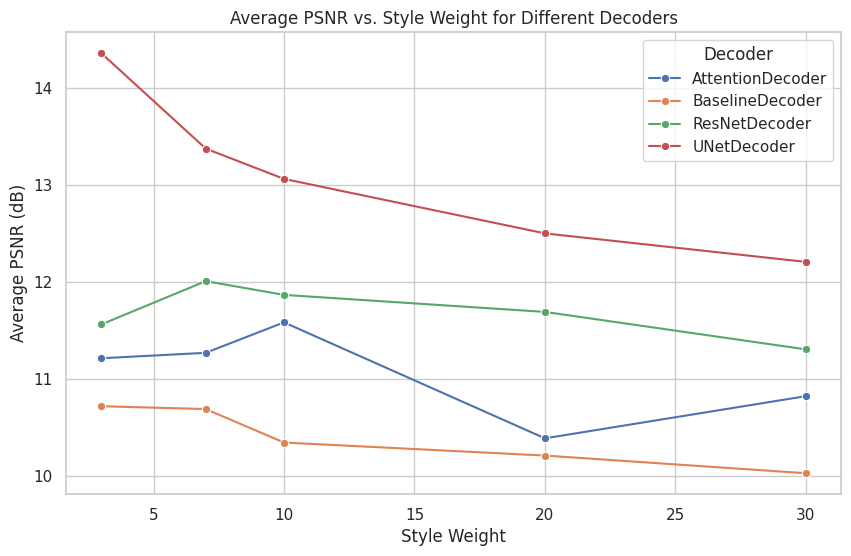

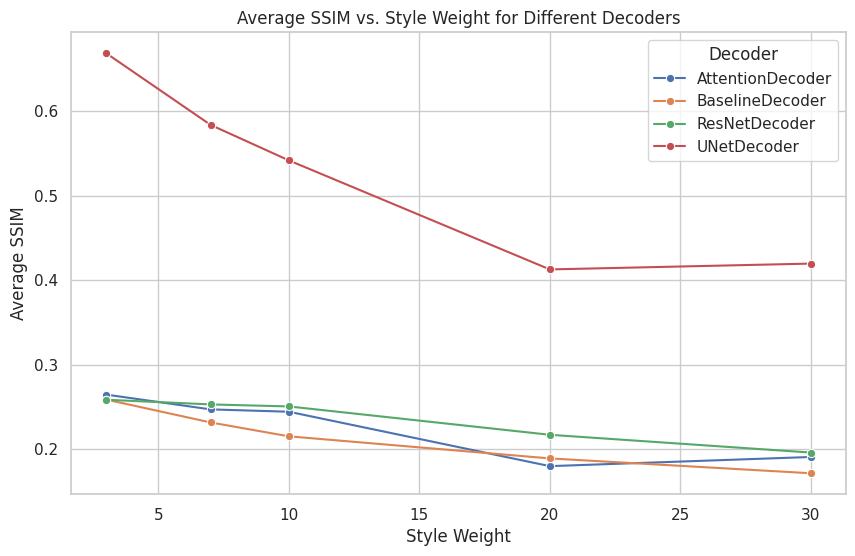

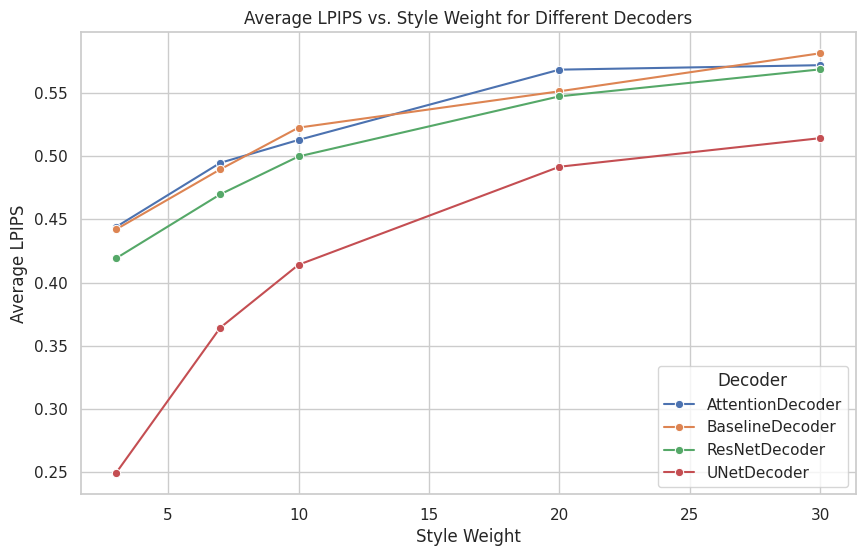

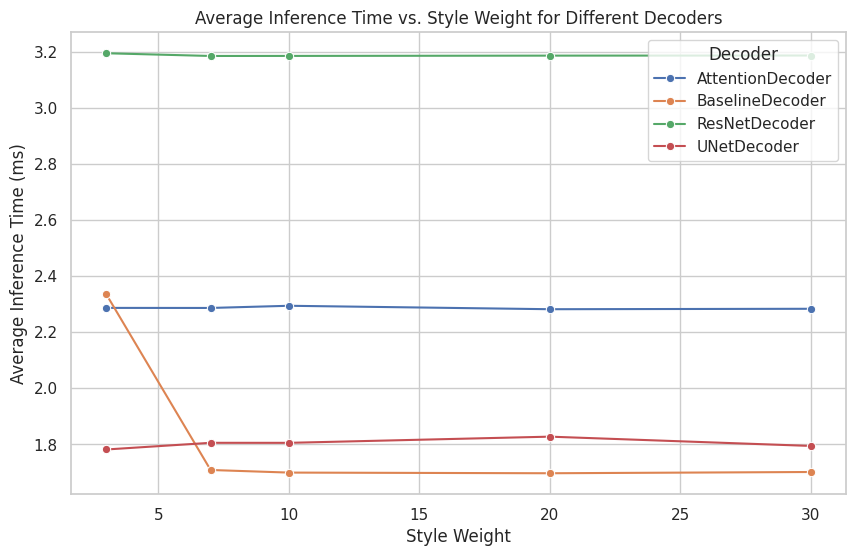


Plots have been generated.


In [16]:
# Load the validation results from the CSV file
try:
    results_df = pd.read_csv("full_validation_results/full_validation_metrics.csv")
except FileNotFoundError:
    print("The file 'full_validation_results/full_validation_metrics.csv' was not found.")
    print("Please make sure you have run the full validation cell first.")
else:
    # --- Calculate and Display Averages ---
    # Group by decoder and style_weight and calculate the mean of the other columns
    numeric_cols = ['psnr', 'ssim', 'lpips', 'inference_time_ms']
    average_metrics = results_df.groupby(['decoder', 'style_weight'])[numeric_cols].mean().reset_index()

    print("--- Average Metrics per Decoder and Style Weight ---")
    print(average_metrics)

    # --- Plotting the Metrics ---
    print("\n--- Generating Plots ---")

    # Set the style for the plots
    sns.set(style="whitegrid")

    # Plot for PSNR
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=average_metrics, x='style_weight', y='psnr', hue='decoder', marker='o')
    plt.title('Average PSNR vs. Style Weight for Different Decoders')
    plt.xlabel('Style Weight')
    plt.ylabel('Average PSNR (dB)')
    plt.legend(title='Decoder')
    plt.grid(True)
    plt.savefig("full_validation_results/average_psnr_plot.png")
    plt.show()


    # Plot for SSIM
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=average_metrics, x='style_weight', y='ssim', hue='decoder', marker='o')
    plt.title('Average SSIM vs. Style Weight for Different Decoders')
    plt.xlabel('Style Weight')
    plt.ylabel('Average SSIM')
    plt.legend(title='Decoder')
    plt.grid(True)
    plt.savefig("full_validation_results/average_ssim_plot.png")
    plt.show()

    # Plot for LPIPS
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=average_metrics, x='style_weight', y='lpips', hue='decoder', marker='o')
    plt.title('Average LPIPS vs. Style Weight for Different Decoders')
    plt.xlabel('Style Weight')
    plt.ylabel('Average LPIPS')
    plt.legend(title='Decoder')
    plt.grid(True)
    plt.savefig("full_validation_results/average_lpips_plot.png")
    plt.show()

    # Plot for Inference Time
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=average_metrics, x='style_weight', y='inference_time_ms', hue='decoder', marker='o')
    plt.title('Average Inference Time vs. Style Weight for Different Decoders')
    plt.xlabel('Style Weight')
    plt.ylabel('Average Inference Time (ms)')
    plt.legend(title='Decoder')
    plt.grid(True)
    plt.savefig("full_validation_results/average_inference_time_plot.png")
    plt.show()

    print("\nPlots have been generated.")